In [220]:
using BSON: @load
using Flux
using Flux.Optimise
using Flux.Optimise: update!
using Flux.Data: DataLoader
using ImageFiltering
using Images
using ImageIO
using MLDatasets: FashionMNIST
using LinearAlgebra
using MLDatasets
using Plots
using Zygote
using FFTW
using Distributions
using SparseArrays
using JLD

In [221]:
"""
    optimise(init_z, loss, opt, tolerance, [out_toggle = 0,][max_iter = 1_000_000])

    Optimization that stops when the gradient is small enough
"""
function optimise(opt, loss; init, tolerance, out_toggle = 0, max_iter = 1_000_000)
    tol2 = tolerance^2
    z = init
    ps = Flux.params(z)
    iter=1
    succ_error = 1.0
    while succ_error > tol2 && (iter <= max_iter || @warn "Max num. iterations reached")
        grads = gradient(() -> loss(z), ps)
        update!(opt, z, grads[z])
        succ_error = sum(abs2, grads[z])
        if out_toggle != 0 && iter % out_toggle == 0
            println("====> In Gradient: Iteration: $iter grad_size: $(sqrt(succ_error)) tolerance: $tolerance  Loss: ", string(loss(z)))
        end
        iter += 1
    end
    return z
end

optimise

In [224]:
function get_rand_model(k,mid,n)
    W₂ = rand(Float64, (n, mid))
    W₁ = rand(Float64, (mid,k))
    return x -> W₂*relu.(W₁*x)
end

get_rand_model (generic function with 1 method)

In [225]:
function sample_fourier(aimed_m, n)
    F = dct(diagm(ones(n)),2)
    sampling = rand(Bernoulli(aimed_m/n), n)
    true_m = sum(sampling)
    return (true_m, F[sampling,:])
end

sample_fourier (generic function with 1 method)

In [226]:
function recover_signal(measurements, measure, model, code_dim)
    function loss(signal_guess)
        return sum(abs2, measure(model(signal_guess)) - measurements)
    end
    
    return model(optimise( Flux.Optimise.Descent(1.2e-4), loss, init=rand(code_dim), tolerance=1e-10, out_toggle=20000))
end

recover_signal (generic function with 1 method)

In [227]:
k = 20
mid = 100
n = 400
aimed_m = 23
num_meas, measure_mat = sample_fourier(aimed_m, n)
measure(x) = measure_mat*x
random_model = get_rand_model(k,mid,n)
#signal in range
true_signal = random_model(rand(Float64, k))
measurements = measure(true_signal);

In [228]:
@time recovered_signal = recover_signal(measurements, measure, random_model, k)
println("The distance between signals is ", norm(recovered_signal - true_signal))
println("The size of the true signal is ", norm(true_signal))

====> In Gradient: Iteration: 20000 grad_size: 5.376850314816695e-7 tolerance: 1.0e-10  Loss: 7.3522066016778316e-6
====> In Gradient: Iteration: 40000 grad_size: 2.0557802237057008e-8 tolerance: 1.0e-10  Loss: 

1.0803042627742248e-8


====> In Gradient: Iteration: 60000 grad_size: 7.89876546510124e-10 tolerance: 1.0e-10  Loss: 1.5951381953646627e-11
 40.274109 seconds (39.80 M allocations: 31.507 GiB, 11.19% gc time, 45.54% compilation time)


The distance between signals is 4.6148643935495427e-5
The size of the true signal is 4793.948627071124


In [ ]:
function subspace_incoherence(F, A)
    α = 0
    m, _ = size(A)
    QR_decomp = qr(A)

    for i in 1:m
        temp = norm(Matrix(QR_decomp.Q)'*F[i,:], 2)
        α = max(α, temp)
    end
    return α
end

function relative_error(z₀, z_est)
    return(norm(z₀ - z_est, 2)/ norm(z₀, 2))
end  

Consider the compressed sensing problem of recovering $x\in\mathbb{R}^n$ from noisy measurements of the form

$$y = A x_{0} + \epsilon, $$

where $\epsilon\in\mathbb{R}^n$ is noise and $A$ is the compressive sensing matrix. We assume the unknown signal $x$ lives in the range of known generative model $G:\mathbb{R}^k \rightarrow \mathbb{R}^n$, i.e. $x_{0} = G(z_0)$ for some $z_0 \in \mathbb{R}^k$. We assume the generative model $G$ is  fully-connected feedforward network of the form 

$$ G(x) = A_d\sigma(A_{d-1} \cdots \sigma(A_1 z)\cdots),$$

where $A_i \in \mathbb{R}^{n_i \times n_{i-1}}$ is the weight matrix and $\sigma(\cdot)$ is the activation function. We
determine the conditions (on $A, G, x_{0}$, \etc) under which it is possible to (approximately) recover $x_{0}$ from noisy linear measurements $y$ by (approximately) solving an optimization problem of the form

$$\argmin_{z \in \mathbb{R}^{k}} \|b - A G(z) \|_{2}. $$

Although this optimzation problem is non-convex, it has been shown that gradient descent and other descent-type alogorithm can provably converge to the global optima. We implement the vanilla gradient descent algorithm below:

In [229]:
function GD_CS(G, y, A, max_iter, stepsize, tolerance, out_toggle)
    _, k = size(Flux.params(G)[1])
    z = randn(k)
    iter = 1
    succ_error = 1
    d(z) = gradient(z -> norm(y - A*G(z))^2, z)[1]

    while iter <= max_iter && succ_error > tolerance
        # d gives the PLUGIn direction
        z -= stepsize * d(z)
        succ_error = norm(stepsize * d(z))
        if iter % out_toggle == 0  
            println("====> In Gradient: Iteration: $iter Successive error: $succ_error")
        end
        iter += 1
    end
    return z
end



GD_CS (generic function with 1 method)

In the next experiment, we consider a one hidden layer network of the form $G(z) = A_2σ(A_1z)$. The inner layer matrix $A_1 \in \mathbb{R}^{n_1\times k}$ has $\mathcal{N}(0,1/n_1)$ entries. For the outer layer matrix $A_2 \in \mathbb{R}^{n_2\times n_1}$ ($n_2 = n$), we take a matrix $A_{21}$ which contains columns randomly subsampled (without replacement) from a $n\times n$ DCT matrix and a random matrix $A_{22}$ which contains $\mathcal{N}(0,1/n_2)$ entries and take its convex combination, i.e. 
$$A_2 = \beta A_{21} + (1-\beta) A_{22}$$
for $\beta \in [0,1]$.

For each $\beta \in [0.7,1]$, we attempt to recover the code vector $z_0$ from measurement of the form $y = A G(z_0)$ where $A \in \mathbb{R}^{m\times n}$ is subsampled DCT matrix (without replacement) by solve the least squares optimzation problem using the gradient descent algorithm. We show the results from 20 trials for each $\beta$ and for all trials, $z_0, A_1, A_{21}$, and $A_{22}$ are fixed. For all experiments, $k = 20, n = 400$, $n_1$ is approximately 100, and $m$ is approximately 160.

In [349]:
#setup a synthetic problem
k = 20
aimed_n1 = 100
x_dim = 400
aimed_m = 200


n1, A = sample_fourier(aimed_n1, x_dim); A = A' #sub-sampled DCT matrix used in convex combination
B = randn(x_dim, n1)/sqrt(x_dim) #random matrix that is used in convex combination
W1 = randn(n1, 20)/sqrt(n1) #random inner layer weight matrix
I(x) = x




stepsize = .5
tolerance = 1e-7
max_iter = 2000
out_toggle = 2001

z = randn(k) # ground code vector

β_list = 0:.1:1
trials = 20
recovery_error_matrix = zeros(trials)
recon_error_matrix = zeros(trials)

α_list = []
F = dct(diagm(ones(x_dim)),2)
for β in β_list
    push!(α_list, subspace_incoherence(F, β*A + (1-β) * B) )
end

for β in β_list
    recovery_error_list = []
    recon_error_list = []
    G = Chain(
        Dense(20, n1, relu, bias = false; init =(out,in) -> W1),
        Dense(n1, x_dim, I, bias = false; init =(out,in) -> β*A + (1-β) * B)
    )    #setup the generative network 


    for trials in 1:trials
        m, F_sub = sample_fourier(aimed_m, x_dim)  # subsampling DCT for measurement matrix
        F_sub = F_sub * sqrt(x_dim)/sqrt(m) #normalization          
        y = F_sub * G(z) # measurement vector using subsampled DCT matrix
        z_rec = GD_CS(G,y,F_sub, max_iter, stepsize, tolerance, out_toggle) # run gradient descent to solve the least squares problem
        push!(recovery_error_list, relative_error(z, z_rec))    
        push!(recon_error_list, relative_error(G(z), G(z_rec)))
    end

    recovery_error_matrix =  hcat(recovery_error_matrix, recovery_error_list)
    recon_error_matrix = hcat(recon_error_matrix, recon_error_list)
end



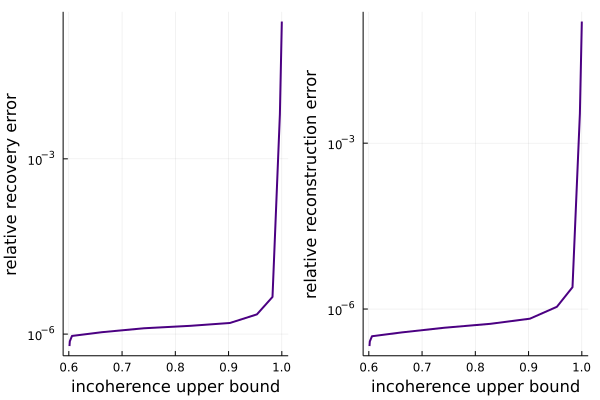

In [358]:
cs = palette([:red,  :orange, :green, :blue, :Indigo], 1000)

average_recov = mean(recovery_error_matrix[:, 2:end], dims=1)'
# std_recov = std(recovery_error_matrix[:, 2:end], dims=1)'
# plot(α_list, average_recov + std_recov, fillrange = max.(0, average_recov - std_recov), fillalpha = .2, c = cs[400], label = false,linecolor = invisible())
p1 = plot(α_list, average_recov, xlabel = "incoherence upper bound", ylabel = "relative recovery error", linewidth = 2, color = cs[1000], label =false, yaxis =:log )


average_recon = mean(recon_error_matrix[:, 2:end], dims=1)'
# std_recon = std(recon_error_matrix[:, 2:end], dims=1)
# # plot(α_list, average_recon + std_recon, fillrange = max.(0, average_recon - std_recon), fillalpha = .2, c = cs[400], label = false, linecolor = invisible())
p2 = plot(α_list, average_recon, xlabel = "incoherence upper bound", ylabel = "relative reconstruction error", linewidth = 2, color = cs[1000], label =false, yaxis =:log  )

plot(p1,p2,layout = 2)
